### Train a Basic Sentiment Classification Model for Future Use

In [18]:
import re
import pandas as pd
import string
import numpy as np
import nltk
from nltk import pos_tag
from nltk.tag import StanfordNERTagger
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, SparsePCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import GridSearchCV # for Hyper parameter tuning

In [19]:
rawData = pd.read_csv('/Users/jojoli/Documents/夏校申请:项目制作/英才计划/正式培养/english/datasets/IMDB Dataset.csv')
rawData.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


#### Preprocessing

In [20]:
def remove_punctuation(text):
    if "<br />" in text:
            text = text.replace("<br />", ' ')
    return text.strip()
rawData['rp_review'] = rawData['review'].apply(remove_punctuation)
rawData.head()

,review,sentiment,rp_review
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming t...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."


In [21]:
# Tokenize -- create a new tokenized column
import re

def tokenize(text):
    toks = re.split('\W+', text)
    return toks

rawData['tok_review'] = rawData['rp_review'].apply(lambda x : tokenize(x.lower()))
rawData.head()

,review,sentiment,rp_review,tok_review
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming t...,"[a, wonderful, little, production, the, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,..."
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,"[basically, there, s, a, family, where, a, lit..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...","[petter, mattei, s, love, in, the, time, of, m..."


In [22]:
# Remove stopwords
from nltk.corpus import stopwords
stw = stopwords.words('english')
# print(stw)

def re_stop(text):
    after = [word for word in text if word not in stw]
    return after

rawData['nostop_review'] = rawData['tok_review'].apply(lambda x : re_stop(x))
rawData.head()

,review,sentiment,rp_review,tok_review,nostop_review
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e..."
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming t...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,"[basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, jake, thinks,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...","[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ..."


In [23]:
# Lemmatize

#nltk.download('omw-1.4')
#nltk.download('wordnet')

wnl = nltk.WordNetLemmatizer()

def lemmatizing(text):
    after = [wnl.lemmatize(word) for word in text]
    return after

rawData['lemm_review'] = rawData['nostop_review'].apply(lambda x : lemmatizing(x))
rawData.head(5)
# rawData.info()

,review,sentiment,rp_review,tok_review,nostop_review,lemm_review
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewer, mentioned, watching, 1, oz, ep..."
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming t...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,"[basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...","[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ...","[petter, mattei, love, time, money, visually, ..."


In [24]:
rawData.to_csv('/Users/jojoli/Documents/夏校申请:项目制作/英才计划/正式培养/english/datasets/IMDB_cleaned.csv')


#### Feature Engineering

In [25]:
df = pd.read_csv('/Users/jojoli/Documents/夏校申请:项目制作/英才计划/正式培养/english/datasets/IMDB_cleaned.csv')
df.head()

,Unnamed: 0,review,sentiment,rp_review,tok_review,nostop_review,lemm_review
0,0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,"['one', 'of', 'the', 'other', 'reviewers', 'ha...","['one', 'reviewers', 'mentioned', 'watching', ...","['one', 'reviewer', 'mentioned', 'watching', '..."
1,1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming t...,"['a', 'wonderful', 'little', 'production', 'th...","['wonderful', 'little', 'production', 'filming...","['wonderful', 'little', 'production', 'filming..."
2,2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,"['i', 'thought', 'this', 'was', 'a', 'wonderfu...","['thought', 'wonderful', 'way', 'spend', 'time...","['thought', 'wonderful', 'way', 'spend', 'time..."
3,3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,"['basically', 'there', 's', 'a', 'family', 'wh...","['basically', 'family', 'little', 'boy', 'jake...","['basically', 'family', 'little', 'boy', 'jake..."
4,4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...","['petter', 'mattei', 's', 'love', 'in', 'the',...","['petter', 'mattei', 'love', 'time', 'money', ...","['petter', 'mattei', 'love', 'time', 'money', ..."


In [10]:
def count_words(text):
    return len(str(text).split())

def count_uniquewords(text):
    return len(set(str(text).split()))

def count_chars(text):
    return len(str(text))

def word_density(text):
    return count_chars(text) / (count_words(text) + 1)

def count_stopwords(text):
    stopwords = [word for word in str(text).split() if word in stw]
    return len(stopwords)

In [11]:
pos_dic = {
    "NN" : "noun", "NNS" : "noun", "NNP": "noun", "NNPS" : "noun",
    "PRP" : "pron", "PRP$" : "pron", "WP" : "pron", "WP$" : "pron",
    "VB" : "verb", "VBD" : "verb", "VBG" : "verb", "VBN" : "verb", "VBP" : "verb", "VBZ": "verb",
    "JJ" : "adj", "JJR" : "adj", "JJS" : "adj",
    "RB"  : "adv", "RBR" : "adv", "RBS" : "adv", "WRB" : "adj"
}

def count_tag_noun(text):
    pos_counts = 0
    for each in pos_tag(str(text).split()):
        if each[1] == 'NN' or each[1] == 'NNP' or each[1] == 'NNPS' or each[1] == 'NNS':
            pos_counts = pos_counts + 1
    return pos_counts

def count_tag_pron(text):
    pos_counts = 0
    for each in pos_tag(str(text).split()):
        if each[1] == 'PRP' or each[1] == 'PRP$' or each[1] == 'WP' or each[1] == 'WP$':
            pos_counts = pos_counts + 1
    return pos_counts

def count_tag_verb(text):
    pos_counts = 0
    for each in pos_tag(str(text).split()):
        if each[1] == 'VB' or each[1] == 'VBD' or each[1] == 'VBG' or each[1] == 'VBN' or each[1] == 'VBP' or each[1] == 'VBZ':
            pos_counts = pos_counts + 1
    return pos_counts

def count_tag_adj(text):
    pos_counts = 0
    for each in pos_tag(str(text).split()):
        if each[1] == 'JJ' or each[1] == 'JJR' or each[1] == 'JJS':
            pos_counts = pos_counts + 1
    return pos_counts

def count_tag_adv(text):
    pos_counts = 0
    for each in pos_tag(str(text).split()):
        if each[1] == 'RB' or each[1] == 'RBR' or each[1] == 'RBS' or each[1] == 'WRB':
            pos_counts = pos_counts + 1
    return pos_counts

In [12]:
df['word_count'] = df['review'].apply(lambda x:count_words(x))
df['unique_word_count'] = df['review'].apply(lambda x:count_uniquewords(x))
df['char_count'] = df['review'].apply(lambda x:count_chars(x))
df['cal_word_density'] = df['review'].apply(lambda x:word_density(x))
df['stopword_count'] = df['review'].apply(lambda x:count_stopwords(x))

df['unique_vs_words'] = df['unique_word_count']/df['word_count']
df['stop_vs_words'] = df['stopword_count']/df['word_count']

df['pos_count_noun'] = df['review'].apply(lambda x:count_tag_noun(x))
df['pos_count_verb'] = df['review'].apply(lambda x:count_tag_verb(x))
df['pos_count_pron'] = df['review'].apply(lambda x:count_tag_pron(x))
df['pos_count_adj'] = df['review'].apply(lambda x:count_tag_adj(x))
df['pos_count_adv'] = df['review'].apply(lambda x:count_tag_adv(x))

df.head()

,Unnamed: 0,review,sentiment,rp_review,tok_review,nostop_review,lemm_review,word_count,unique_word_count,char_count,cal_word_density,stopword_count,unique_vs_words,stop_vs_words,pos_count_noun,pos_count_verb,pos_count_pron,pos_count_adj,pos_count_adv
0,0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,"['one', 'of', 'the', 'other', 'reviewers', 'ha...","['one', 'reviewers', 'mentioned', 'watching', ...","['one', 'reviewer', 'mentioned', 'watching', '...",307,208,1761,5.717532,122,0.677524,0.397394,88,62,19,35,17
1,1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming t...,"['a', 'wonderful', 'little', 'production', 'th...","['wonderful', 'little', 'production', 'filming...","['wonderful', 'little', 'production', 'filming...",162,114,998,6.122699,62,0.703704,0.382716,44,26,9,16,18
2,2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,"['i', 'thought', 'this', 'was', 'a', 'wonderfu...","['thought', 'wonderful', 'way', 'spend', 'time...","['thought', 'wonderful', 'way', 'spend', 'time...",166,121,926,5.544910,70,0.728916,0.421687,42,34,10,16,9
3,3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,"['basically', 'there', 's', 'a', 'family', 'wh...","['basically', 'family', 'little', 'boy', 'jake...","['basically', 'family', 'little', 'boy', 'jake...",138,96,748,5.381295,58,0.695652,0.420290,40,25,7,7,10
4,4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...","['petter', 'mattei', 's', 'love', 'in', 'the',...","['petter', 'mattei', 'love', 'time', 'money', ...","['petter', 'mattei', 'love', 'time', 'money', ...",230,152,1317,5.701299,92,0.660870,0.400000,78,33,9,27,7


In [13]:
# Using TF-IDF
vectorizer = TfidfVectorizer()
df_text = vectorizer.fit_transform(df['lemm_review']).toarray()
print(df_text.shape)

df_tfidf = pd.DataFrame(df_text)
df_targeted = df.sentiment
"""
features = ['word_count', 'unique_word_count', 'char_count',
       'cal_word_density', 'stopword_count', 'unique_vs_words',
       'stop_vs_words', 'pos_count_noun', 'pos_count_verb',
       'pos_count_adj', 'pos_count_pron', 'pos_count_adv']
df_all = pd.merge(df_tfidf,df[features],left_index=True, right_index=True)
"""
X_train, X_test, y_train, y_test = train_test_split(df_tfidf, df_targeted ,test_size=0.3, random_state=42)

(50000, 92212)


              precision    recall  f1-score   support

    negative       0.86      0.87      0.87      7382
    positive       0.87      0.87      0.87      7618

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

--------------The Accuracy of the model----------------------------
Accuracy of Random Forest on test set: 0.86846667


Text(0.5, 1.05, 'Confusion_matrix')

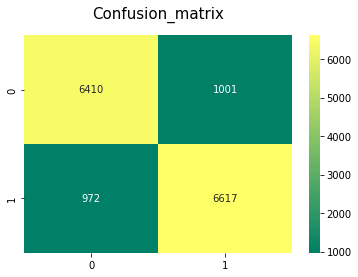

In [14]:
# Random Forest

import seaborn as sns
import matplotlib.pyplot as plt

model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_pred, y_test))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of Random Forest on test set: {:.8f}'.format(accuracy_score(y_pred, y_test)))

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

              precision    recall  f1-score   support

    negative       0.88      0.85      0.87      7714
    positive       0.85      0.88      0.86      7286

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000

--------------The Accuracy of the model----------------------------
Accuracy of Multinomial Naive Bayes on test set: 0.86406667


Text(0.5, 1.05, 'Confusion_matrix')

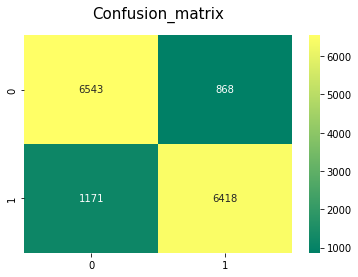

In [15]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB

multinomialnb = MultinomialNB()
multinomialnb.fit(X_train, y_train)
y_pred_2 = multinomialnb.predict(X_test)
print(metrics.classification_report(y_pred_2, y_test))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of Multinomial Naive Bayes on test set: {:.8f}'.format(accuracy_score(y_pred_2, y_test)))

sns.heatmap(confusion_matrix(y_test,y_pred_2),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

              precision    recall  f1-score   support

    negative       0.89      0.90      0.89      7300
    positive       0.90      0.89      0.90      7700

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

--------------The Accuracy of the model----------------------------
Accuracy of SVM on test set: 0.89606667


Text(0.5, 1.05, 'Confusion_matrix')

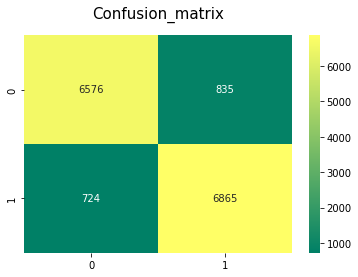

In [16]:
# SVM

from sklearn.svm import LinearSVC

linearsvc = LinearSVC()
linearsvc.fit(X_train, y_train)
y_pred_3 = linearsvc.predict(X_test)
print(metrics.classification_report(y_pred_3, y_test))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of SVM on test set: {:.8f}'.format(accuracy_score(y_pred_3, y_test)))

sns.heatmap(confusion_matrix(y_test,y_pred_3),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

              precision    recall  f1-score   support

    negative       0.89      0.90      0.89      7300
    positive       0.90      0.89      0.90      7700

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

--------------The Accuracy of the model----------------------------
Accuracy of SVM on test set: 0.89606667


Text(0.5, 1.05, 'Confusion_matrix')

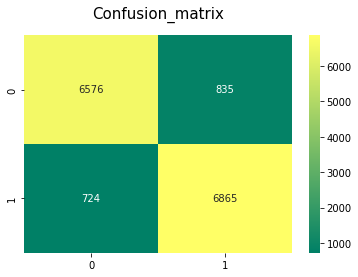

In [17]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

filename = '/Users/jojoli/Documents/夏校申请:项目制作/英才计划/正式培养/english/code/basic_model_svc.sav'
pickle.dump(linearsvc, open(filename, 'wb'))

# load the model
load_model = pickle.load(open(filename, 'rb'))

y_pred_4 = load_model.predict(X_test)
print(metrics.classification_report(y_pred_4, y_test))
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of SVM on test set: {:.8f}'.format(accuracy_score(y_pred_4, y_test)))

sns.heatmap(confusion_matrix(y_test,y_pred_4),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

### Use it for CoreNLP

In [ ]:
# 读取read_coref的结果
# 把结果格式变成训练集的格式
# 用训练好的model进行标注
